In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from codecarbon import track_emissions

In [2]:
# Configurações iniciais
TASK = "Ischaemia"  # "Infection" ou "Ischaemia"
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
MODEL_NAME = "resnet50"  # "efficientnet" ou "resnet50"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Pré-processamento de Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
root_dir = "../data/ischaemia"


# 2. Dataset Customizado
class DFUDataset(Dataset):
    def __init__(self, root_dir, task=TASK, transform=None):
        self.root_dir = root_dir
        self.task = task

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.identifiers = []  # Novo campo para identificadores únicos

        # Validate that root_dir is a valid path
        if not isinstance(root_dir, str):
            raise TypeError(f"Expected root_dir to be a string, but got {type(root_dir).__name__}")

        print("TASK: " + TASK)

        positive_dir = os.path.join(root_dir, "Aug-Positive")
        negative_dir = os.path.join(root_dir, "Aug-Negative")


        # Carregar imagens positivas
        for img_name in os.listdir(positive_dir):
            self.image_paths.append(os.path.join(positive_dir, img_name))
            self.labels.append(1)
            # Extrair identificador único (ex: "imagem" de "imagem_1X_M.jpg")
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

        # Carregar imagens negativas
        for img_name in os.listdir(negative_dir):
            self.image_paths.append(os.path.join(negative_dir, img_name))
            self.labels.append(0)
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# 3. Modelo com Regularização
def create_model():
    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1  # Ou ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif MODEL_NAME == "efficientnet":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Ou EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 1)
        )
    return model.to(DEVICE)

In [6]:
# 6. Cálculo de Métricas
def calculate_metrics(true, preds):
    preds_class = (preds > 0.5).astype(int)
    return {
        'auc': roc_auc_score(true, preds),
        'pr_auc': average_precision_score(true, preds),
        'f1': f1_score(true, preds_class),
        'accuracy': accuracy_score(true, preds_class),
        'precision': precision_score(true, preds_class),
        'recall': recall_score(true, preds_class),
        'confusion_matrix': confusion_matrix(true, preds_class)
    }

In [7]:
# 5. Função de Avaliação
@track_emissions(output_dir="../reports/emissions", output_file="ischaemia_resnet50.csv") 
def evaluate_model(model, loader, criterion):
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return np.mean(losses), metrics

In [8]:
# 4. Função de Treinamento com Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, fold):
    best_loss = float('inf')
    patience_counter = 0
    patience = 3

    history = {
        'train_loss': [],
        'val_loss': [],
        'auc': [],
        'f1': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validação
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Registrar métricas
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['auc'].append(val_metrics['auc'])
        history['f1'].append(val_metrics['f1'])

        print(f'Fold {fold}, Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val AUC: {val_metrics["auc"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    import os
    output_dir = "../models/ischaemia"
    os.makedirs(output_dir, exist_ok=True)
    # Salva o modelo final do fold
    last_path = os.path.join(output_dir, f"last_model_fold{fold}.pth")
    torch.save(model.state_dict(), last_path)

    return history

In [9]:
# 7. Grad-CAM
def generate_grad_cam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_tensor.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
    return visualization

In [10]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Cores para diferentes folds
    colors = ['b', 'g', 'r', 'c', 'm']

    # Plot Loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], linestyle='--', color=colors[i], label=f'Fold {i+1} Train')
        plt.plot(epochs, history['val_loss'], linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot AUC
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['auc'])+1)
        plt.plot(epochs, history['auc'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot F1-Score
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['f1'])+1)
        plt.plot(epochs, history['f1'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig('training_histories.png')
    plt.show()

In [11]:
# 8. Validação Cruzada
@track_emissions(output_dir="../reports/emissions", output_file="ischaemia_resnet50_cv.csv") 
def cross_validation():

    dataset = DFUDataset("../data/ischaemia", transform=transform)
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Alterado para StratifiedGroupKFold

    all_metrics = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=np.zeros(len(dataset.labels)),  # Dummy data
        y=dataset.labels,
        groups=dataset.identifiers  # Grupos dos identificadores
    )):
        print(f'\nFold {fold+1}/5')

        # Split adicional: 80% treino, 20% teste interno
        train_idx, test_idx = train_test_split(
            train_idx,
            test_size=0.2,
            stratify=np.array(dataset.labels)[train_idx],
            random_state=42
        )

        # Split datasets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_subsampler)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Inicialização
        model = create_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # L2 regularization

        history = train_model(model, train_loader, val_loader, criterion, optimizer, fold+1)
        fold_histories.append(history)

        plot_training_histories(fold_histories)

        # Avaliação no conjunto de teste interno
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, test_metrics = evaluate_model(model, test_loader, criterion)

        # Carregar melhor modelo e avaliar
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, metrics = evaluate_model(model, val_loader, criterion)

         # Adicione as métricas de teste
        all_metrics.append({
            'fold': fold+1,
            'val_metrics': metrics,
            'test_metrics': test_metrics
        })

    pd.DataFrame(fold_histories).to_csv('../reports/metrics/training_history_ischae_resnet50.csv', index=False)


    # Processar all_metrics para formato tabular
    metrics_rows = []
    for m in all_metrics:
        row = {
            'fold': m['fold'],
            **{f'val_{k}': v for k, v in m['val_metrics'].items()},
            **{f'test_{k}': v for k, v in m['test_metrics'].items()}
        }
        metrics_rows.append(row)

    pd.DataFrame(metrics_rows).to_csv('../reports/metrics/fold_metrics_ischae_resnet50.csv', index=False)

    # Relatório Final
    print("\nResultados da Validação Cruzada:")

    # Para métricas de validação
    print("\n--- Métricas de Validação ---")
    for key in all_metrics[0]['val_metrics']:
        if key != 'confusion_matrix':
            mean_val = np.mean([m['val_metrics'][key] for m in all_metrics])
            std_val = np.std([m['val_metrics'][key] for m in all_metrics])
            print(f'Val_{key.upper()}: {mean_val:.4f} ± {std_val:.4f}')

    # Para métricas de teste interno
    print("\n--- Métricas de Teste Interno ---")
    for key in all_metrics[0]['test_metrics']:
        if key != 'confusion_matrix':
            mean_test = np.mean([m['test_metrics'][key] for m in all_metrics])
            std_test = np.std([m['test_metrics'][key] for m in all_metrics])
            print(f'Test_{key.upper()}: {mean_test:.4f} ± {std_test:.4f}')

    return fold_histories, all_metrics

[codecarbon WARNING @ 10:33:11] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:33:11] [setup] RAM Tracking...
[codecarbon INFO @ 10:33:11] [setup] CPU Tracking...
[codecarbon WARNING @ 10:33:12] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 10:33:12] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 10:33:12] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 10:33:12] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:33:12] [setup] GPU Tracking...
[codecarbon INFO @ 10:33:12] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:33:12] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c

TASK: Ischaemia

Fold 1/5


[codecarbon INFO @ 10:33:31] Energy consumed for RAM : 0.000158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:33:31] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:33:31] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 10:33:31] Energy consumed for all GPUs : 0.000039 kWh. Total GPU Power : 9.458731023457165 W
[codecarbon INFO @ 10:33:31] 0.000375 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:33:46] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:33:46] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:33:46] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 10:33:46] Energy consumed for all GPUs : 0.000081 kWh. Total GPU Power : 9.952036546460993 W
[codecarbon INFO @ 10:33:46] 0.000752 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:34

Fold 1, Epoch 1/100
Train Loss: 0.2263 | Val Loss: 0.2026
Val AUC: 0.9795, F1: 0.9296


[codecarbon INFO @ 10:42:32] Energy consumed for RAM : 0.005857 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:42:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:32] Energy consumed for All CPU : 0.006552 kWh
[codecarbon INFO @ 10:42:32] Energy consumed for all GPUs : 0.001167 kWh. Total GPU Power : 7.6278441842129725 W
[codecarbon INFO @ 10:42:32] 0.013576 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:42:47] Energy consumed for RAM : 0.006015 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:42:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:42:47] Energy consumed for All CPU : 0.006729 kWh
[codecarbon INFO @ 10:42:47] Energy consumed for all GPUs : 0.001203 kWh. Total GPU Power : 8.7274313814085 W
[codecarbon INFO @ 10:42:47] 0.013947 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:43:

Fold 1, Epoch 2/100
Train Loss: 0.0813 | Val Loss: 0.1882
Val AUC: 0.9815, F1: 0.9244


[codecarbon INFO @ 10:52:47] Energy consumed for RAM : 0.012347 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:52:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:52:47] Energy consumed for All CPU : 0.013813 kWh
[codecarbon INFO @ 10:52:47] Energy consumed for all GPUs : 0.002522 kWh. Total GPU Power : 8.100190140580759 W
[codecarbon INFO @ 10:52:47] 0.028682 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:53:02] Energy consumed for RAM : 0.012505 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 10:53:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 10:53:02] Energy consumed for All CPU : 0.013991 kWh
[codecarbon INFO @ 10:53:02] Energy consumed for all GPUs : 0.002556 kWh. Total GPU Power : 8.048849351633205 W
[codecarbon INFO @ 10:53:02] 0.029051 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 10:53

Fold 1, Epoch 3/100
Train Loss: 0.0340 | Val Loss: 0.1920
Val AUC: 0.9805, F1: 0.9276


[codecarbon INFO @ 11:04:02] Energy consumed for RAM : 0.019470 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:02] Energy consumed for All CPU : 0.021783 kWh
[codecarbon INFO @ 11:04:02] Energy consumed for all GPUs : 0.003972 kWh. Total GPU Power : 7.071653031644204 W
[codecarbon INFO @ 11:04:02] 0.045225 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:04:17] Energy consumed for RAM : 0.019629 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:04:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:04:17] Energy consumed for All CPU : 0.021960 kWh
[codecarbon INFO @ 11:04:17] Energy consumed for all GPUs : 0.004002 kWh. Total GPU Power : 7.165881958881305 W
[codecarbon INFO @ 11:04:17] 0.045591 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:04

Fold 1, Epoch 4/100
Train Loss: 0.0168 | Val Loss: 0.2180
Val AUC: 0.9765, F1: 0.9191


[codecarbon INFO @ 11:15:03] Energy consumed for RAM : 0.026435 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:15:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:03] Energy consumed for All CPU : 0.029575 kWh
[codecarbon INFO @ 11:15:03] Energy consumed for all GPUs : 0.005753 kWh. Total GPU Power : 11.750073430189303 W
[codecarbon INFO @ 11:15:03] 0.061764 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:15:18] Energy consumed for RAM : 0.026594 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:15:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:15:18] Energy consumed for All CPU : 0.029752 kWh
[codecarbon INFO @ 11:15:18] Energy consumed for all GPUs : 0.005803 kWh. Total GPU Power : 11.841937659622566 W
[codecarbon INFO @ 11:15:18] 0.062148 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:

Fold 1, Epoch 5/100
Train Loss: 0.0132 | Val Loss: 0.2256
Val AUC: 0.9828, F1: 0.9082
Early stopping at epoch 5


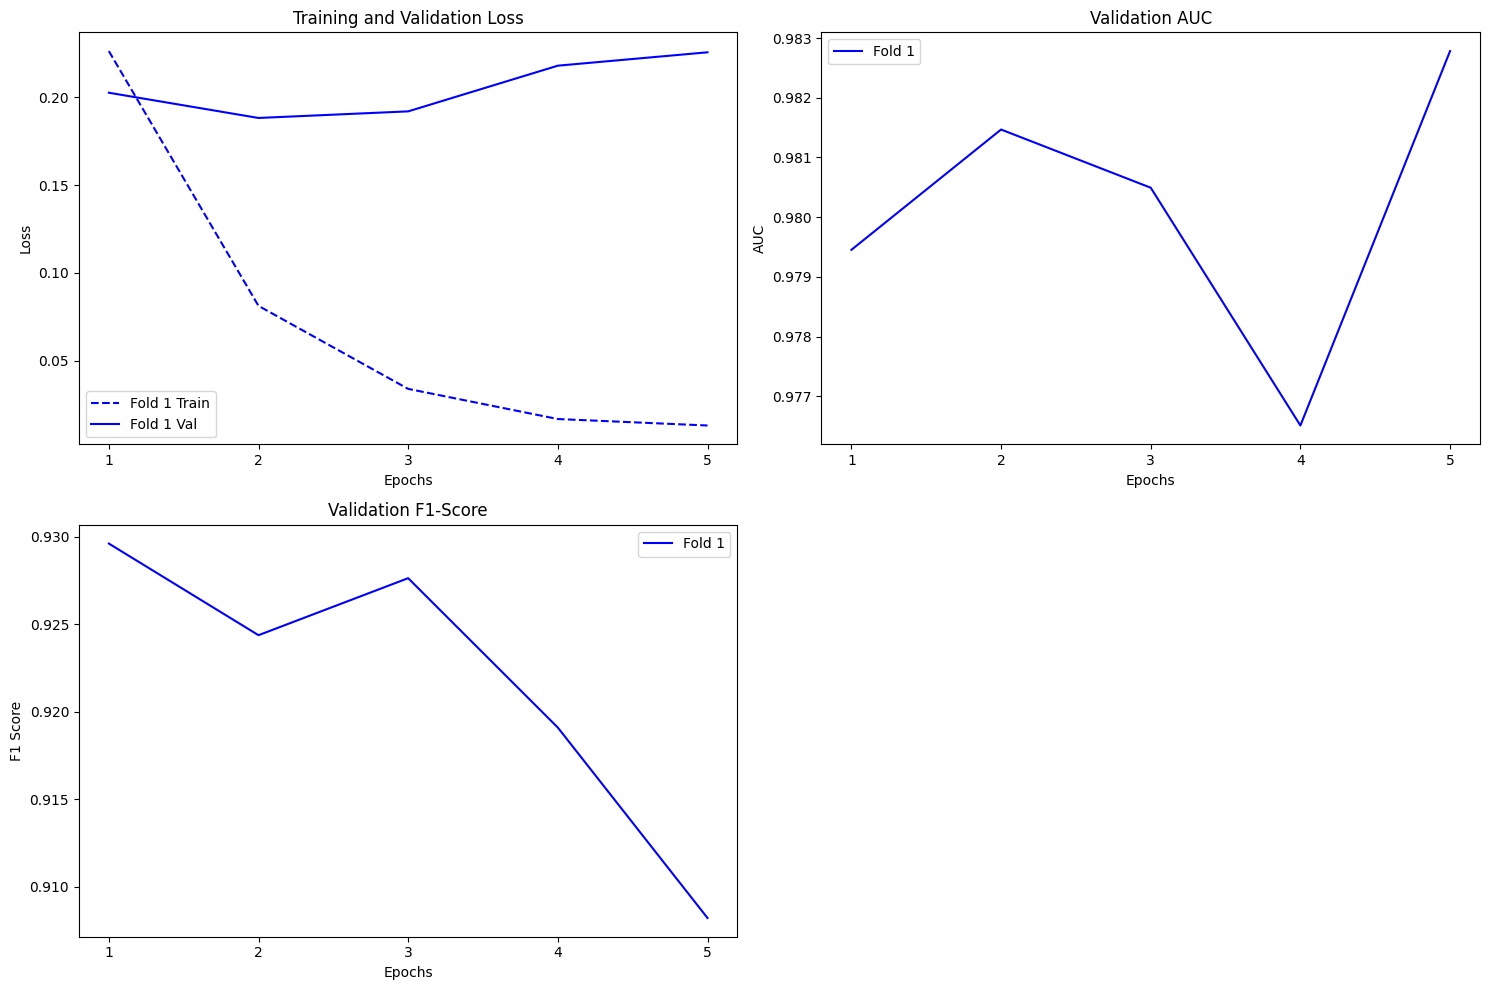

[codecarbon WARNING @ 11:25:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 11:25:10] [setup] RAM Tracking...
[codecarbon INFO @ 11:25:10] [setup] CPU Tracking...
[codecarbon WARNING @ 11:25:10] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 11:25:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 11:25:10] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 11:25:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 11:25:10] [setup] GPU Tracking...
[codecarbon INFO @ 11:25:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 11:25:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 2/5


[codecarbon INFO @ 11:27:03] Energy consumed for RAM : 0.034033 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:27:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:03] Energy consumed for All CPU : 0.038075 kWh
[codecarbon INFO @ 11:27:03] Energy consumed for all GPUs : 0.008157 kWh. Total GPU Power : 11.787395938708025 W
[codecarbon INFO @ 11:27:03] 0.080265 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:27:18] Energy consumed for RAM : 0.034192 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:27:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:27:18] Energy consumed for All CPU : 0.038252 kWh
[codecarbon INFO @ 11:27:18] Energy consumed for all GPUs : 0.008206 kWh. Total GPU Power : 11.898185863547996 W
[codecarbon INFO @ 11:27:18] 0.080650 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:

Fold 2, Epoch 1/100
Train Loss: 0.2134 | Val Loss: 0.2660
Val AUC: 0.9569, F1: 0.8916


[codecarbon INFO @ 11:37:04] Energy consumed for RAM : 0.040364 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:37:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:04] Energy consumed for All CPU : 0.045158 kWh
[codecarbon INFO @ 11:37:04] Energy consumed for all GPUs : 0.010155 kWh. Total GPU Power : 11.91400130113825 W
[codecarbon INFO @ 11:37:04] 0.095677 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:37:19] Energy consumed for RAM : 0.040523 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:37:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:37:19] Energy consumed for All CPU : 0.045335 kWh
[codecarbon INFO @ 11:37:19] Energy consumed for all GPUs : 0.010205 kWh. Total GPU Power : 11.936779268755824 W
[codecarbon INFO @ 11:37:19] 0.096062 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:3

Fold 2, Epoch 2/100
Train Loss: 0.0765 | Val Loss: 0.3228
Val AUC: 0.9498, F1: 0.8761


[codecarbon INFO @ 11:47:34] Energy consumed for RAM : 0.047013 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:47:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:47:34] Energy consumed for All CPU : 0.052596 kWh
[codecarbon INFO @ 11:47:34] Energy consumed for all GPUs : 0.012233 kWh. Total GPU Power : 11.753326312887793 W
[codecarbon INFO @ 11:47:34] 0.111842 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:47:49] Energy consumed for RAM : 0.047171 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:47:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:47:49] Energy consumed for All CPU : 0.052773 kWh
[codecarbon INFO @ 11:47:49] Energy consumed for all GPUs : 0.012282 kWh. Total GPU Power : 11.780374498296451 W
[codecarbon INFO @ 11:47:49] 0.112227 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:

Fold 2, Epoch 3/100
Train Loss: 0.0333 | Val Loss: 0.3412
Val AUC: 0.9517, F1: 0.8937


[codecarbon INFO @ 11:59:34] Energy consumed for RAM : 0.054611 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:59:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:34] Energy consumed for All CPU : 0.061097 kWh
[codecarbon INFO @ 11:59:34] Energy consumed for all GPUs : 0.014602 kWh. Total GPU Power : 11.806439490296817 W
[codecarbon INFO @ 11:59:34] 0.130310 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 11:59:49] Energy consumed for RAM : 0.054770 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 11:59:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 11:59:49] Energy consumed for All CPU : 0.061274 kWh
[codecarbon INFO @ 11:59:49] Energy consumed for all GPUs : 0.014652 kWh. Total GPU Power : 11.935086809502065 W
[codecarbon INFO @ 11:59:49] 0.130695 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:

Fold 2, Epoch 4/100
Train Loss: 0.0154 | Val Loss: 0.3510
Val AUC: 0.9508, F1: 0.8914
Early stopping at epoch 4


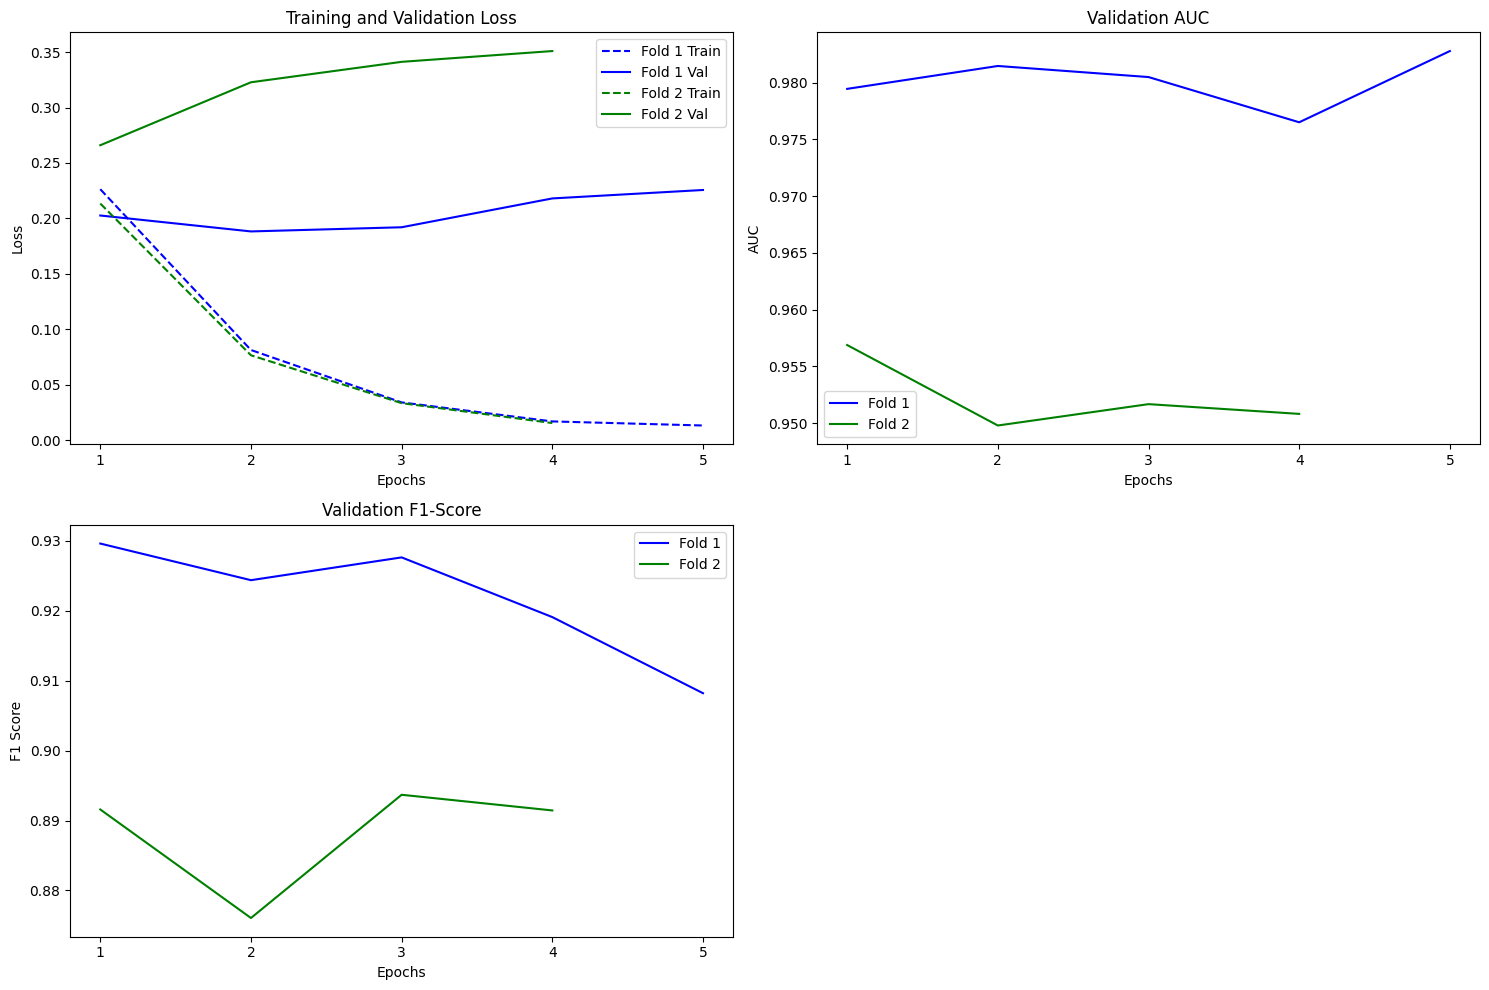

[codecarbon WARNING @ 12:10:31] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:10:31] [setup] RAM Tracking...
[codecarbon INFO @ 12:10:31] [setup] CPU Tracking...
[codecarbon WARNING @ 12:10:31] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 12:10:31] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 12:10:31] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 12:10:31] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:10:31] [setup] GPU Tracking...
[codecarbon INFO @ 12:10:31] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:10:31] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 3/5


[codecarbon INFO @ 12:12:20] Energy consumed for RAM : 0.062684 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:20] Energy consumed for All CPU : 0.070129 kWh
[codecarbon INFO @ 12:12:20] Energy consumed for all GPUs : 0.017132 kWh. Total GPU Power : 11.958390462697452 W
[codecarbon INFO @ 12:12:20] 0.149945 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:12:35] Energy consumed for RAM : 0.062843 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:12:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:12:35] Energy consumed for All CPU : 0.070305 kWh
[codecarbon INFO @ 12:12:35] Energy consumed for all GPUs : 0.017181 kWh. Total GPU Power : 11.883247519271748 W
[codecarbon INFO @ 12:12:35] 0.150329 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:

Fold 3, Epoch 1/100
Train Loss: 0.2314 | Val Loss: 0.2191
Val AUC: 0.9709, F1: 0.9256


[codecarbon INFO @ 12:22:05] Energy consumed for RAM : 0.068858 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:22:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:05] Energy consumed for All CPU : 0.077035 kWh
[codecarbon INFO @ 12:22:05] Energy consumed for all GPUs : 0.019072 kWh. Total GPU Power : 11.931272888924797 W
[codecarbon INFO @ 12:22:05] 0.164965 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:22:20] Energy consumed for RAM : 0.069016 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:22:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:22:20] Energy consumed for All CPU : 0.077212 kWh
[codecarbon INFO @ 12:22:20] Energy consumed for all GPUs : 0.019122 kWh. Total GPU Power : 12.013193625073953 W
[codecarbon INFO @ 12:22:20] 0.165350 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:

Fold 3, Epoch 2/100
Train Loss: 0.0856 | Val Loss: 0.2316
Val AUC: 0.9687, F1: 0.9147


[codecarbon INFO @ 12:32:51] Energy consumed for RAM : 0.075667 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:32:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:32:51] Energy consumed for All CPU : 0.084653 kWh
[codecarbon INFO @ 12:32:51] Energy consumed for all GPUs : 0.021203 kWh. Total GPU Power : 11.994037029739113 W
[codecarbon INFO @ 12:32:51] 0.181523 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:33:06] Energy consumed for RAM : 0.075825 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:33:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:33:06] Energy consumed for All CPU : 0.084830 kWh
[codecarbon INFO @ 12:33:06] Energy consumed for all GPUs : 0.021252 kWh. Total GPU Power : 11.863864713448725 W
[codecarbon INFO @ 12:33:06] 0.181907 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:

Fold 3, Epoch 3/100
Train Loss: 0.0390 | Val Loss: 0.2471
Val AUC: 0.9684, F1: 0.9120


[codecarbon INFO @ 12:44:36] Energy consumed for RAM : 0.083107 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:36] Energy consumed for All CPU : 0.092976 kWh
[codecarbon INFO @ 12:44:36] Energy consumed for all GPUs : 0.023525 kWh. Total GPU Power : 11.903584664864665 W
[codecarbon INFO @ 12:44:36] 0.199607 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:44:51] Energy consumed for RAM : 0.083265 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:44:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:44:51] Energy consumed for All CPU : 0.093153 kWh
[codecarbon INFO @ 12:44:51] Energy consumed for all GPUs : 0.023575 kWh. Total GPU Power : 12.000493193132398 W
[codecarbon INFO @ 12:44:51] 0.199993 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:

Fold 3, Epoch 4/100
Train Loss: 0.0184 | Val Loss: 0.2507
Val AUC: 0.9703, F1: 0.9237
Early stopping at epoch 4


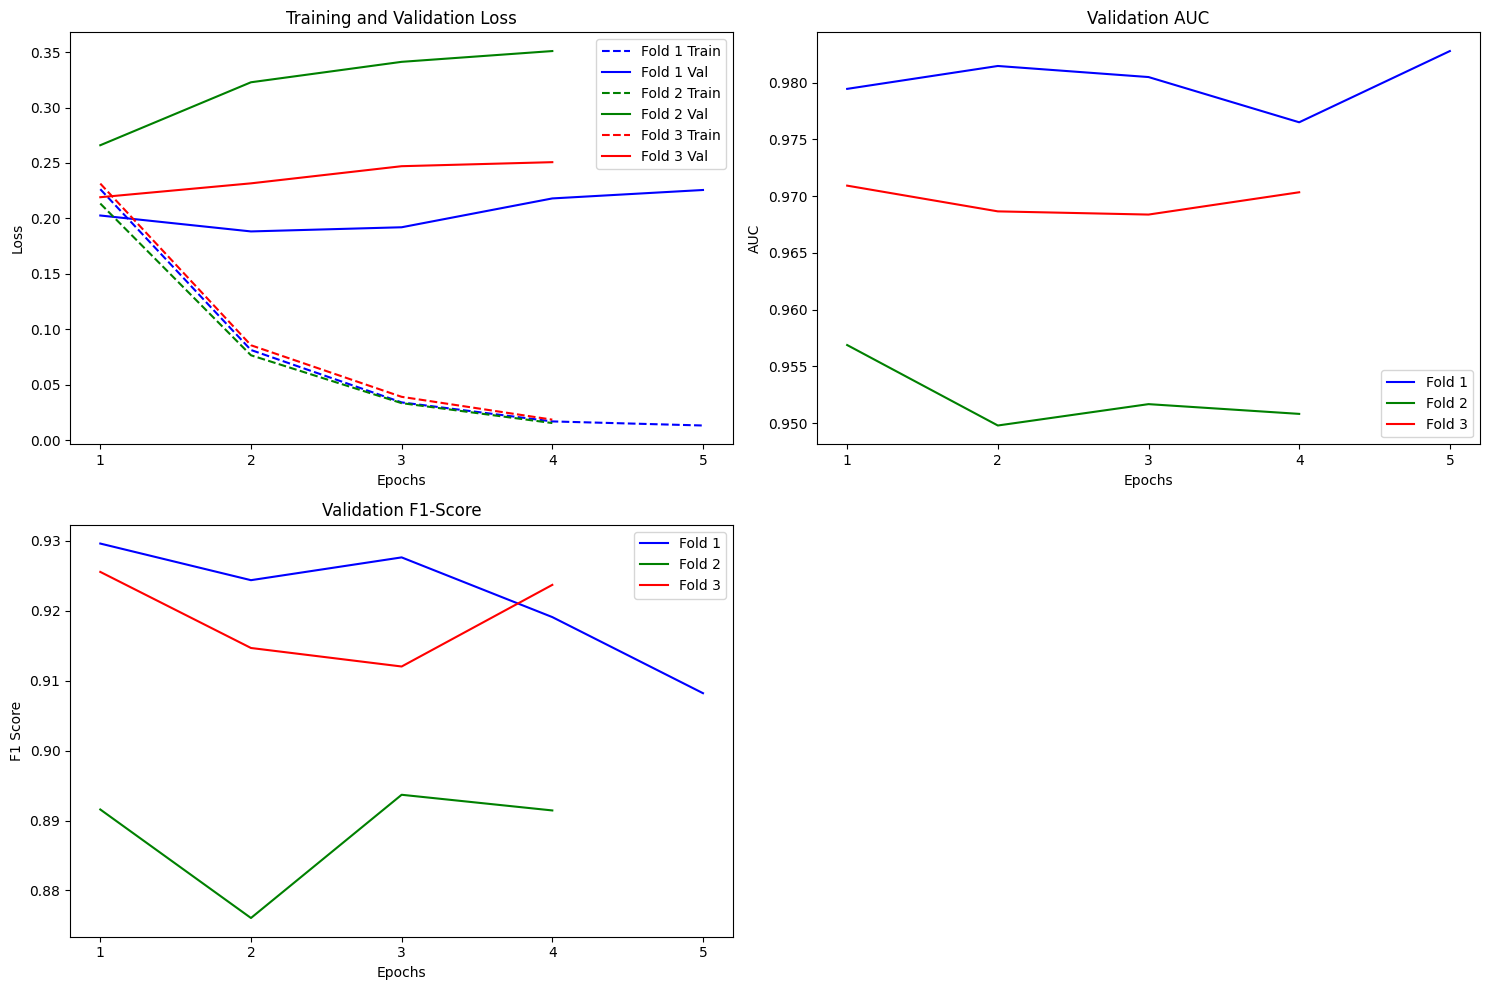

[codecarbon WARNING @ 12:55:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 12:55:27] [setup] RAM Tracking...
[codecarbon INFO @ 12:55:27] [setup] CPU Tracking...
[codecarbon WARNING @ 12:55:27] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 12:55:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 12:55:27] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 12:55:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 12:55:27] [setup] GPU Tracking...
[codecarbon INFO @ 12:55:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 12:55:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 4/5


[codecarbon INFO @ 12:57:22] Energy consumed for RAM : 0.091180 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:57:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:57:22] Energy consumed for All CPU : 0.102007 kWh
[codecarbon INFO @ 12:57:22] Energy consumed for all GPUs : 0.026043 kWh. Total GPU Power : 11.951833680303535 W
[codecarbon INFO @ 12:57:22] 0.219229 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 12:57:22] 0.002521 g.CO2eq/s mean an estimation of 79.50744145032634 kg.CO2eq/year
[codecarbon INFO @ 12:57:37] Energy consumed for RAM : 0.091338 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 12:57:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 12:57:37] Energy consumed for All CPU : 0.102184 kWh
[codecarbon INFO @ 12:57:37] Energy consumed for all GPUs : 0.026093 kWh. Total GPU Power : 11.978019293056123 W
[codecarbon INFO @ 12:57:37] 0.2

Fold 4, Epoch 1/100
Train Loss: 0.2174 | Val Loss: 0.2562
Val AUC: 0.9618, F1: 0.8779


[codecarbon INFO @ 13:07:07] Energy consumed for RAM : 0.097352 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:07:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:07] Energy consumed for All CPU : 0.108913 kWh
[codecarbon INFO @ 13:07:07] Energy consumed for all GPUs : 0.027986 kWh. Total GPU Power : 11.705485524915527 W
[codecarbon INFO @ 13:07:07] 0.234251 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:07:22] Energy consumed for RAM : 0.097511 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:07:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:07:22] Energy consumed for All CPU : 0.109090 kWh
[codecarbon INFO @ 13:07:22] Energy consumed for all GPUs : 0.028035 kWh. Total GPU Power : 11.837006727464452 W
[codecarbon INFO @ 13:07:22] 0.234636 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:

Fold 4, Epoch 2/100
Train Loss: 0.0859 | Val Loss: 0.2300
Val AUC: 0.9711, F1: 0.8932


[codecarbon INFO @ 13:17:52] Energy consumed for RAM : 0.104158 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:17:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:17:52] Energy consumed for All CPU : 0.116527 kWh
[codecarbon INFO @ 13:17:52] Energy consumed for all GPUs : 0.030127 kWh. Total GPU Power : 12.12585657420386 W
[codecarbon INFO @ 13:17:52] 0.250813 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:18:07] Energy consumed for RAM : 0.104317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:18:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:18:07] Energy consumed for All CPU : 0.116704 kWh
[codecarbon INFO @ 13:18:07] Energy consumed for all GPUs : 0.030178 kWh. Total GPU Power : 12.083657994443648 W
[codecarbon INFO @ 13:18:07] 0.251199 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:1

Fold 4, Epoch 3/100
Train Loss: 0.0377 | Val Loss: 0.3044
Val AUC: 0.9647, F1: 0.8785


[codecarbon INFO @ 13:29:53] Energy consumed for RAM : 0.111756 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:29:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:29:53] Energy consumed for All CPU : 0.125027 kWh
[codecarbon INFO @ 13:29:53] Energy consumed for all GPUs : 0.032394 kWh. Total GPU Power : 10.858744585954001 W
[codecarbon INFO @ 13:29:53] 0.269177 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:30:08] Energy consumed for RAM : 0.111914 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:30:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:30:08] Energy consumed for All CPU : 0.125204 kWh
[codecarbon INFO @ 13:30:08] Energy consumed for all GPUs : 0.032440 kWh. Total GPU Power : 11.017855357870015 W
[codecarbon INFO @ 13:30:08] 0.269558 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:

Fold 4, Epoch 4/100
Train Loss: 0.0175 | Val Loss: 0.3740
Val AUC: 0.9594, F1: 0.8705


[codecarbon INFO @ 13:40:53] Energy consumed for RAM : 0.118720 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:40:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:40:53] Energy consumed for All CPU : 0.132818 kWh
[codecarbon INFO @ 13:40:53] Energy consumed for all GPUs : 0.034390 kWh. Total GPU Power : 10.878688853153488 W
[codecarbon INFO @ 13:40:53] 0.285927 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:41:08] Energy consumed for RAM : 0.118878 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:41:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:41:08] Energy consumed for All CPU : 0.132995 kWh
[codecarbon INFO @ 13:41:08] Energy consumed for all GPUs : 0.034436 kWh. Total GPU Power : 11.111089869321901 W
[codecarbon INFO @ 13:41:08] 0.286309 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:

Fold 4, Epoch 5/100
Train Loss: 0.0112 | Val Loss: 0.3216
Val AUC: 0.9634, F1: 0.8936
Early stopping at epoch 5


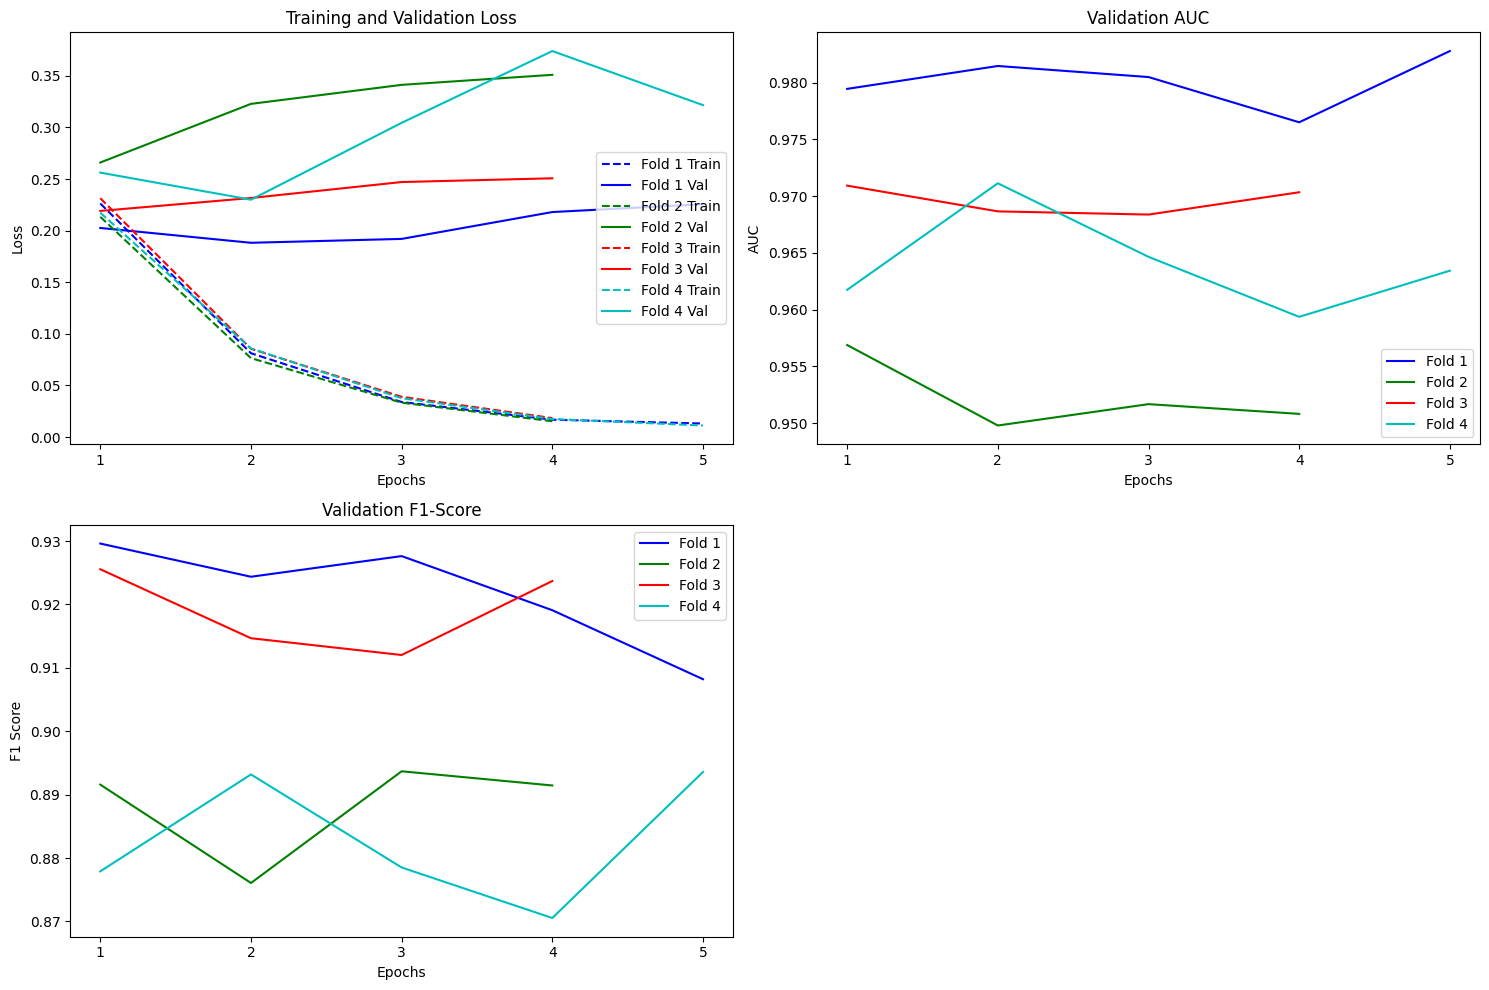

[codecarbon WARNING @ 13:51:14] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 13:51:14] [setup] RAM Tracking...
[codecarbon INFO @ 13:51:14] [setup] CPU Tracking...
[codecarbon WARNING @ 13:51:14] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 13:51:14] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 13:51:14] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 13:51:14] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:51:14] [setup] GPU Tracking...
[codecarbon INFO @ 13:51:14] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 13:51:14] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 5/5


[codecarbon INFO @ 13:53:08] Energy consumed for RAM : 0.126474 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:53:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:53:08] Energy consumed for All CPU : 0.141493 kWh
[codecarbon INFO @ 13:53:08] Energy consumed for all GPUs : 0.036603 kWh. Total GPU Power : 10.900037078998103 W
[codecarbon INFO @ 13:53:08] 0.304571 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:53:23] Energy consumed for RAM : 0.126633 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 13:53:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 13:53:23] Energy consumed for All CPU : 0.141671 kWh
[codecarbon INFO @ 13:53:23] Energy consumed for all GPUs : 0.036649 kWh. Total GPU Power : 11.002372677693417 W
[codecarbon INFO @ 13:53:23] 0.304952 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:

Fold 5, Epoch 1/100
Train Loss: 0.2342 | Val Loss: 0.1698
Val AUC: 0.9867, F1: 0.9466


[codecarbon INFO @ 14:03:09] Energy consumed for RAM : 0.132805 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:03:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:03:09] Energy consumed for All CPU : 0.148576 kWh
[codecarbon INFO @ 14:03:09] Energy consumed for all GPUs : 0.038433 kWh. Total GPU Power : 11.024534337954154 W
[codecarbon INFO @ 14:03:09] 0.319813 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:03:24] Energy consumed for RAM : 0.132963 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:03:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:03:24] Energy consumed for All CPU : 0.148753 kWh
[codecarbon INFO @ 14:03:24] Energy consumed for all GPUs : 0.038479 kWh. Total GPU Power : 11.100032299937336 W
[codecarbon INFO @ 14:03:24] 0.320195 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:

Fold 5, Epoch 2/100
Train Loss: 0.0873 | Val Loss: 0.1699
Val AUC: 0.9821, F1: 0.9348


[codecarbon INFO @ 14:13:54] Energy consumed for RAM : 0.139610 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:13:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:13:54] Energy consumed for All CPU : 0.156190 kWh
[codecarbon INFO @ 14:13:54] Energy consumed for all GPUs : 0.040395 kWh. Total GPU Power : 11.119050179523693 W
[codecarbon INFO @ 14:13:54] 0.336194 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:14:09] Energy consumed for RAM : 0.139768 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:14:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:14:09] Energy consumed for All CPU : 0.156367 kWh
[codecarbon INFO @ 14:14:09] Energy consumed for all GPUs : 0.040442 kWh. Total GPU Power : 11.279767204625504 W
[codecarbon INFO @ 14:14:09] 0.336576 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:

Fold 5, Epoch 3/100
Train Loss: 0.0395 | Val Loss: 0.1913
Val AUC: 0.9798, F1: 0.9277


[codecarbon INFO @ 14:26:09] Energy consumed for RAM : 0.147366 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:26:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:26:09] Energy consumed for All CPU : 0.164866 kWh
[codecarbon INFO @ 14:26:09] Energy consumed for all GPUs : 0.042650 kWh. Total GPU Power : 10.812079700592665 W
[codecarbon INFO @ 14:26:09] 0.354882 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:26:24] Energy consumed for RAM : 0.147524 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:26:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:26:24] Energy consumed for All CPU : 0.165043 kWh
[codecarbon INFO @ 14:26:24] Energy consumed for all GPUs : 0.042696 kWh. Total GPU Power : 11.000346936801597 W
[codecarbon INFO @ 14:26:24] 0.355263 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:

Fold 5, Epoch 4/100
Train Loss: 0.0150 | Val Loss: 0.3004
Val AUC: 0.9740, F1: 0.8908
Early stopping at epoch 4


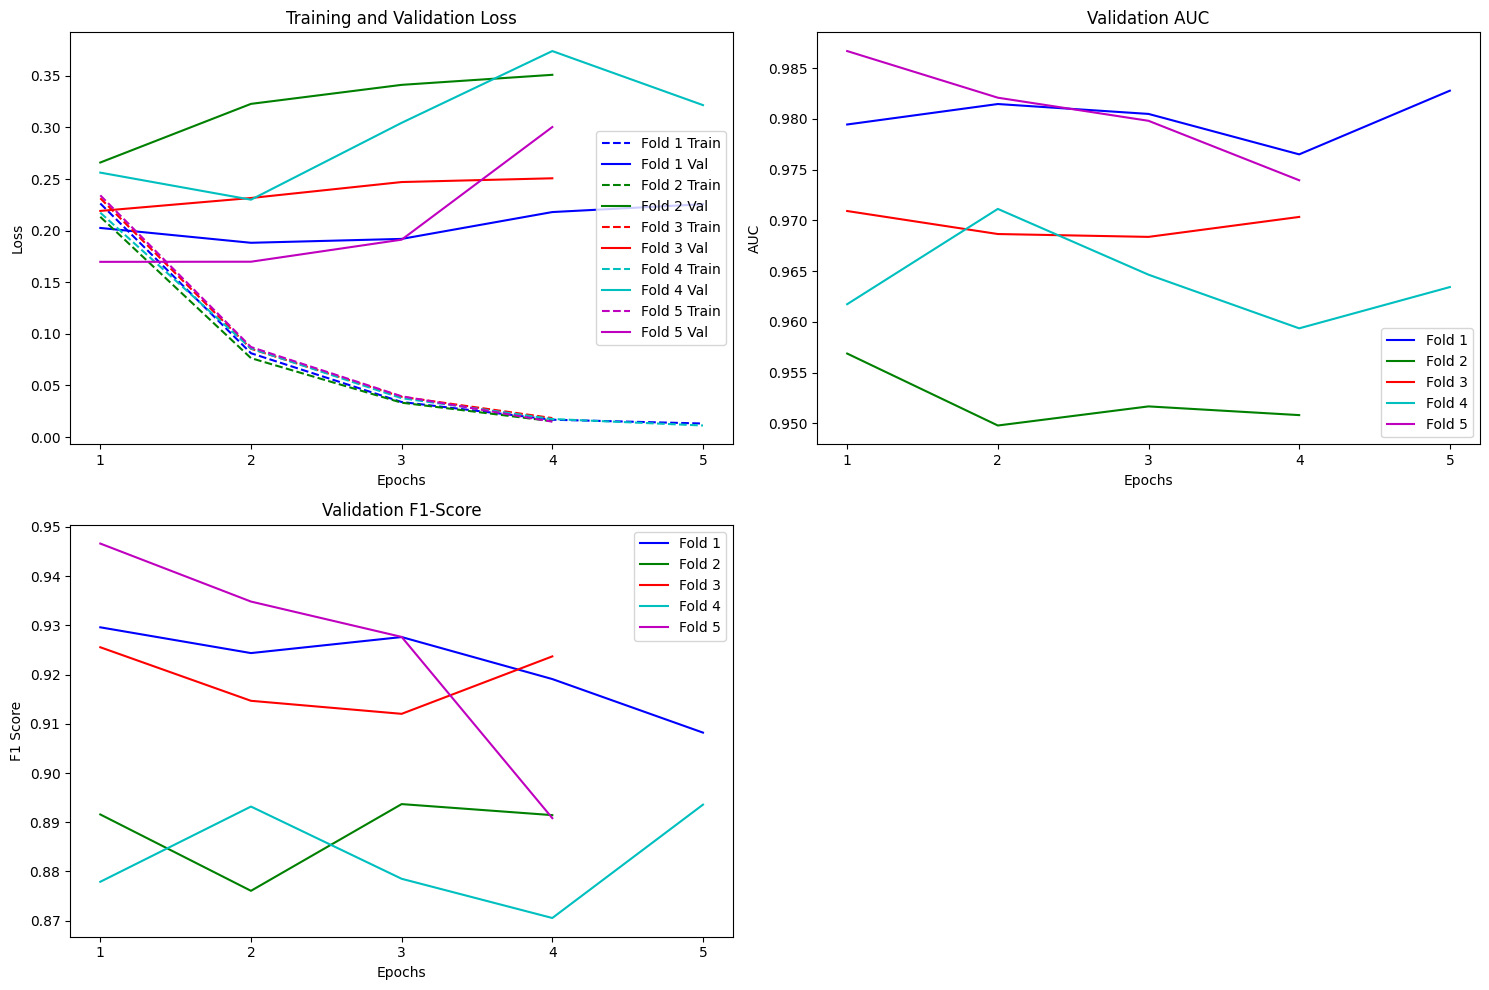

[codecarbon WARNING @ 14:37:10] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:37:10] [setup] RAM Tracking...
[codecarbon INFO @ 14:37:10] [setup] CPU Tracking...
[codecarbon WARNING @ 14:37:10] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 14:37:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 14:37:10] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 14:37:10] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:37:10] [setup] GPU Tracking...
[codecarbon INFO @ 14:37:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:37:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Resultados da Validação Cruzada:

--- Métricas de Validação ---
Val_AUC: 0.9734 ± 0.0103
Val_PR_AUC: 0.9747 ± 0.0099
Val_F1: 0.9163 ± 0.0211
Val_ACCURACY: 0.9177 ± 0.0201
Val_PRECISION: 0.9314 ± 0.0257
Val_RECALL: 0.9029 ± 0.0376

--- Métricas de Teste Interno ---
Test_AUC: 0.9906 ± 0.0052
Test_PR_AUC: 0.9899 ± 0.0054
Test_F1: 0.9552 ± 0.0176
Test_ACCURACY: 0.9547 ± 0.0180
Test_PRECISION: 0.9471 ± 0.0242
Test_RECALL: 0.9635 ± 0.0121
CPU times: total: 3d 22h 3min 47s
Wall time: 4h 5min 44s


In [12]:
%%time
# Executar
if __name__ == "__main__":
    fold_histories, all_metrics = cross_validation()

    # Exemplo Grad-CAM
    # model = create_model().eval()
    # sample_img, _ = dataset[0]
    # target_layer = model.layer4[-1] if MODEL_NAME == "resnet50" else model.features[-1]
    # cam_image = generate_grad_cam(model, sample_img.to(DEVICE), target_layer)
    #
    # plt.imshow(cam_image)
    # plt.title('Grad-CAM Visualization')
    # plt.axis('off')
    # plt.show()